# Project Title: Enhancing Pneumonia Detection From Chest X-rays Using Advanced Transfer Learning & Model Interpretation

### Group Members: Raja Muppidi , Bhuvana Murki

#### Step 1:  Importing and Setting Up Dependencies

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import os

#### Step2: Data Exploration

In [2]:
# Declaring path to the root directory of the dataset, which contains subdirectories for 'train' and 'test'

data_dir = '/Users/raja/Desktop/Career/Masters/Universities/mtu/Fall2023/Clinical Decision and Support System/Final Project/dataset/chest_xray'

# Printing the list of items (files and directories) in the root directory
print(os.listdir(data_dir))

# Identify the classes (subdirectories) in the 'train' directory of the dataset
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['PNEUMONIA', 'NORMAL']


In [3]:
pneumonia_images = os.listdir(data_dir + "/train/PNEUMONIA")
print('No. of training images for Pneumonia:', len(pneumonia_images))
print()
print(pneumonia_images[:5])

No. of training images for Pneumonia: 3883

['BACTERIA-4038442-0001.jpeg', 'BACTERIA-8034950-0011.jpeg', 'BACTERIA-292199-0002.jpeg', 'BACTERIA-2092977-0003.jpeg', 'BACTERIA-4407438-0002.jpeg']


In [4]:
normal_images = os.listdir(data_dir + "/train/NORMAL")
print('No. of training images for Normal:', len(normal_images))
print()
print(normal_images[:5])

No. of training images for Normal: 1349

['NORMAL-2552119-0002.jpeg', 'NORMAL-7298141-0001.jpeg', 'NORMAL-3411116-0002.jpeg', 'NORMAL-1619233-0001.jpeg', 'NORMAL-7327513-0001.jpeg']


The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 132.4655 and the standard deviation is 61.7923


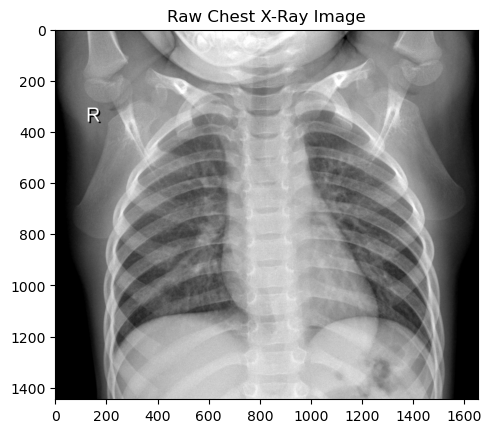

In [5]:
# Investigate a single image
img_dir = os.path.join(data_dir, 'train', 'NORMAL')  # Change to the directory containing the image you want to investigate
images = os.listdir(img_dir)

# Get the first image from the directory
first_image = images[0]
img1 = plt.imread(os.path.join(img_dir, first_image))
plt.imshow(img1, cmap='gray')

pixels = imread(os.path.join(img_dir, first_image))

plt.title('Raw Chest X-Ray Image')
print(f"The maximum pixel value is {pixels.max():.4f} and the minimum is {pixels.min():.4f}")
print(f"The mean value of the pixels is {pixels.mean():.4f} and the standard deviation is {pixels.std():.4f}")

### Step 3: Data Preprocessing

In [6]:
train_transformation = tt.Compose([
    tt.Resize((224, 224)),
    tt.RandomHorizontalFlip(),
    tt.RandomRotation(10),
    tt.RandomGrayscale(p=0.1),
    tt.RandomAffine(translate=(0.05, 0.05), degrees=0),
    tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    tt.ToTensor(),
    tt.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
# Create a dataset for the training set
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), transform=train_transformation)


# Define the batch size for training
batch_size = 32

# Create a DataLoader for the training dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [10]:
# Get the class names from the dataset
class_names = train_dataset.classes

# Display the class names
print(class_names)

['NORMAL', 'PNEUMONIA']


In [27]:
test_transformation = tt.Compose([
    tt.Resize((224, 224)),
    tt.ToTensor(),
    tt.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create a dataset for the test set
test_dataset = ImageFolder(os.path.join(data_dir, 'test'), transform=test_transformation)

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [8]:
# Get the class names from the dataset
class_names = train_dataset.classes

# Display the class names and their corresponding labels
for label, class_name in enumerate(class_names):
    print(f"Label {label}: {class_name}")

Label 0: NORMAL
Label 1: PNEUMONIA


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Example Image (Tensor):
tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1

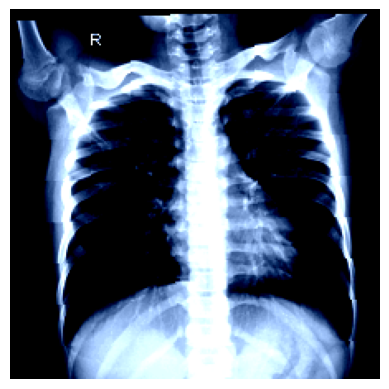

In [9]:
# Select an example image from the dataset
example_image, label = train_dataset[0]


# Display the example image as a tensor
print("Example Image (Tensor):")
print(example_image)


# Display the label of the example image
print("Label:", label)

# Convert the tensor back to a NumPy array for visualization
example_image = example_image.permute(1, 2, 0).numpy()

# Display the example image using matplotlib
plt.imshow(example_image)
plt.axis('off')  # Remove axis
plt.show()

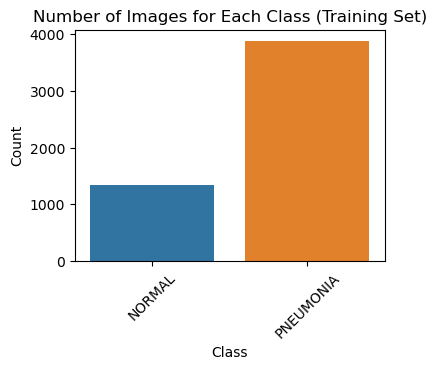

In [11]:
# Get the class names from the dataset
class_names = train_dataset.classes

# Count the number of images for each class in the training set
class_counts = [0] * len(class_names)

for img, label in train_dataset:
    class_counts[label] += 1

# Create a bar plot using seaborn
plt.figure(figsize=(4, 3))
sns.barplot(x=class_names, y=class_counts)
plt.title('Number of Images for Each Class (Training Set)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

#### Calculating Class weights 

In [12]:
import torch

# Replace these with the counts of your classes
count_normal = len(normal_images)  # Replace with the actual count of the "Normal" class
count_pneumonia = len(pneumonia_images)  # Replace with the actual count of the "Pneumonia" class

# Calculate the total number of samples
total_samples = count_normal + count_pneumonia

# Calculate the class weights
class_weight_normal = total_samples / (2.0 * count_normal)
class_weight_pneumonia = total_samples / (2.0 * count_pneumonia)

# Create a tensor with the class weights
class_weights = torch.Tensor([class_weight_normal, class_weight_pneumonia])

print("Class Weights:")
print(class_weights)

Class Weights:
tensor([1.9392, 0.6737])


#### Loss Function Definition

In [13]:
import torch.nn as nn

# Define the loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [14]:
# Function for plotting samples
def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,8))
    for i in range(len(samples)):
        image = cv2.cvtColor(imread(samples[i]), cv2.COLOR_BGR2RGB)
        ax[i//5][i%5].imshow(image)
        if i<5:
            ax[i//5][i%5].set_title("Normal", fontsize=20)
        else:
            ax[i//5][i%5].set_title("Pneumonia", fontsize=20)
        ax[i//5][i%5].axis('off')

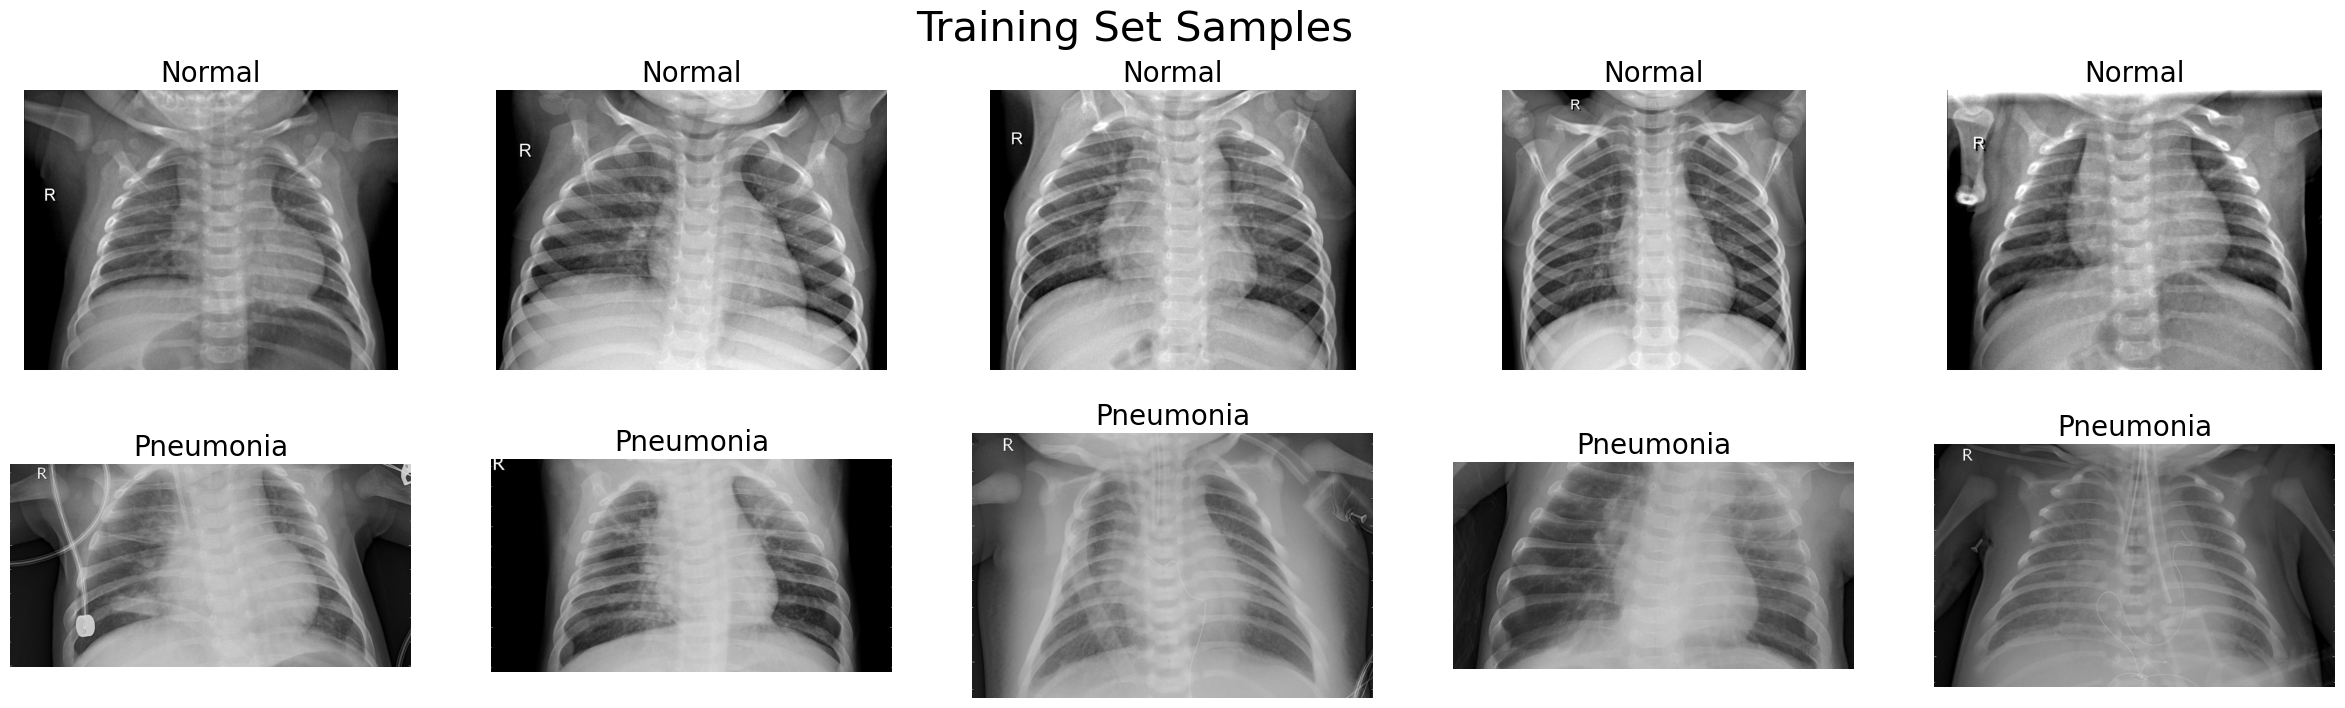

In [15]:
## Plot training samples
rand_samples = random.sample([os.path.join(data_dir+'/train/NORMAL', filename) 
                              for filename in os.listdir(data_dir+'/train/NORMAL')], 5) + \
    random.sample([os.path.join(data_dir+'/train/PNEUMONIA', filename) 
                   for filename in os.listdir(data_dir+'/train/PNEUMONIA')], 5)

plot_samples(rand_samples)
plt.suptitle('Training Set Samples', fontsize=30)
plt.show()

## Step 4: Transfer Learning

### ResNet-50

In [16]:
import torch.optim as optim

In [17]:
# Define the model 
resnet50 = models.resnet50(pretrained=True)

/Users/raja/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/raja/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
# Modify the fully connected layer to match the number of classes in your dataset
in_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(in_features, len(class_names))

In [19]:
# Define the optimizer
learning_rate = 0.001 
optimizer = optim.Adam(resnet50.parameters(), lr=learning_rate)

In [20]:
# Define the number of epochs
num_epochs = 10 

In [21]:
# Move the model to the appropriate device (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
# Training loop
for epoch in range(num_epochs):
    resnet50.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  
        outputs = resnet50(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculating the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        # Update statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Print statistics for the current epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {running_loss / len(train_loader):.3f} - Training Accuracy: {100 * correct / total:.2f}%")

Epoch [1/10] - Loss: 0.201 - Training Accuracy: 92.35%
Epoch [2/10] - Loss: 0.150 - Training Accuracy: 94.55%
Epoch [3/10] - Loss: 0.129 - Training Accuracy: 95.13%
Epoch [4/10] - Loss: 0.109 - Training Accuracy: 95.66%
Epoch [5/10] - Loss: 0.104 - Training Accuracy: 96.01%
Epoch [6/10] - Loss: 0.098 - Training Accuracy: 96.04%
Epoch [7/10] - Loss: 0.096 - Training Accuracy: 96.56%
Epoch [8/10] - Loss: 0.083 - Training Accuracy: 96.83%
Epoch [9/10] - Loss: 0.107 - Training Accuracy: 96.04%
Epoch [10/10] - Loss: 0.089 - Training Accuracy: 96.56%


In [23]:
# Saving the trained model
torch.save(resnet50.state_dict(), 'resnet50_pneumonia_detection.pth')

##### ResNet-50 Trained Model Evaluation

In [24]:
# Evaluate the trained model on the test set
resnet50.eval()  # Set the model to evaluation mode
correct = 0
total = 0

In [25]:
# Lists to store predicted labels and true labels
predicted_labels = []
true_labels = []

In [28]:
# Disable gradient computation during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, predicted = outputs.max(1)

        # Update lists
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Lists to store predicted labels and true labels
predicted_labels = []
true_labels = []

# Disable gradient computation during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, predicted = outputs.max(1)

        # Update lists
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays for consistency
true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)

# Calculate accuracy
accuracy = accuracy_score(true_labels_np, predicted_labels_np)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels_np, predicted_labels_np)
recall = recall_score(true_labels_np, predicted_labels_np)
f1 = f1_score(true_labels_np, predicted_labels_np)

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")


Accuracy: 93.91%
Precision: 95.36%
Recall: 94.87%
F1 Score: 95.12%


In [35]:
# Load the saved model
model = models.resnet50(pretrained=False)
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, len(class_names))
model.load_state_dict(torch.load('resnet50_pneumonia_detection.pth'))
model.eval()

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Create DataLoader for the validation dataset
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Lists to store predicted labels and true labels
predicted_labels = []
true_labels = []

# Disable gradient computation during evaluation
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        # Update lists
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

/Users/raja/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/raja/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Validation Accuracy: 95.51%
Validation Precision: 100.00%
Validation Recall: 94.10%
Validation F1 Score: 96.96%


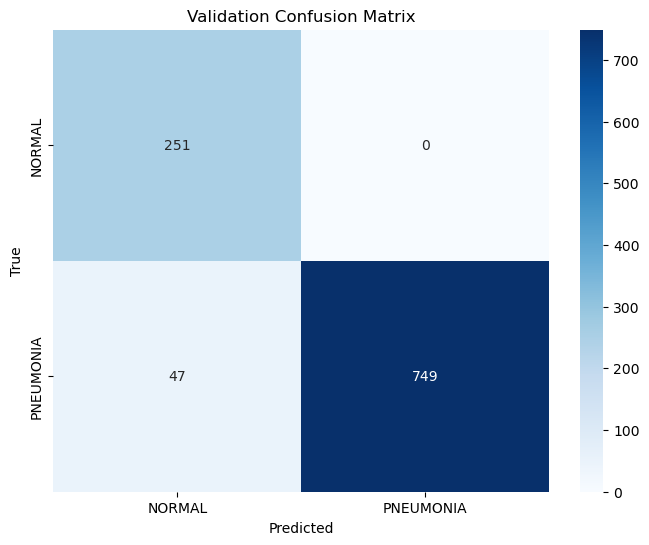

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert to numpy arrays for consistency
true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)

# Calculate accuracy
accuracy = accuracy_score(true_labels_np, predicted_labels_np)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels_np, predicted_labels_np)
recall = recall_score(true_labels_np, predicted_labels_np)
f1 = f1_score(true_labels_np, predicted_labels_np)

print(f"Validation Precision: {precision * 100:.2f}%")
print(f"Validation Recall: {recall * 100:.2f}%")
print(f"Validation F1 Score: {f1 * 100:.2f}%")

# Plot the confusion matrix
conf_matrix = confusion_matrix(true_labels_np, predicted_labels_np)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

### DenseNet Model

In [37]:
import torch.optim as optim
from torchvision import models

# Load pre-trained DenseNet model
densenet = models.densenet121(pretrained=True)

# Modify the final fully connected layer
in_features = densenet.classifier.in_features
densenet.classifier = nn.Linear(in_features, len(class_names))

# Define the optimizer
learning_rate = 0.001
optimizer_densenet = optim.Adam(densenet.parameters(), lr=learning_rate)

# Move the model to the appropriate device
densenet.to(device)

# Training loop
for epoch in range(num_epochs):
    densenet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer_densenet.zero_grad()
        outputs = densenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_densenet.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {running_loss / len(train_loader):.3f} - Training Accuracy: {100 * correct / total:.2f}%")

/Users/raja/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/raja/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10] - Loss: 0.174 - Training Accuracy: 93.74%
Epoch [2/10] - Loss: 0.130 - Training Accuracy: 95.22%
Epoch [3/10] - Loss: 0.091 - Training Accuracy: 96.63%
Epoch [4/10] - Loss: 0.094 - Training Accuracy: 96.32%
Epoch [5/10] - Loss: 0.080 - Training Accuracy: 96.87%
Epoch [6/10] - Loss: 0.078 - Training Accuracy: 97.11%
Epoch [7/10] - Loss: 0.071 - Training Accuracy: 97.49%
Epoch [8/10] - Loss: 0.068 - Training Accuracy: 97.51%
Epoch [9/10] - Loss: 0.067 - Training Accuracy: 97.42%
Epoch [10/10] - Loss: 0.068 - Training Accuracy: 97.63%


In [38]:
# Saving the trained model
torch.save(densenet.state_dict(), 'densenet_pneumonia_detection.pth')

##### DenseNet Trained Model Evaluation

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Lists to store predicted labels and true labels for test set
predicted_labels_test = []
true_labels_test = []

# Test set evaluation
densenet.eval()
correct_test = 0
total_test = 0

with torch.no_grad():
    for images_test, labels_test in test_loader:
        images_test, labels_test = images_test.to(device), labels_test.to(device)
        outputs_test = densenet(images_test)
        _, predicted_test = outputs_test.max(1)

        predicted_labels_test.extend(predicted_test.cpu().numpy())
        true_labels_test.extend(labels_test.cpu().numpy())

        total_test += labels_test.size(0)
        correct_test += predicted_test.eq(labels_test).sum().item()

# Calculate accuracy, precision, recall, and F1 score for test set
accuracy_test = accuracy_score(true_labels_test, predicted_labels_test)
precision_test = precision_score(true_labels_test, predicted_labels_test)
recall_test = recall_score(true_labels_test, predicted_labels_test)
f1_test = f1_score(true_labels_test, predicted_labels_test)

print(f"Test Accuracy: {accuracy_test * 100:.2f}%")
print(f"Test Precision: {precision_test * 100:.2f}%")
print(f"Test Recall: {recall_test * 100:.2f}%")
print(f"Test F1 Score: {f1_test * 100:.2f}%")


Test Accuracy: 92.79%
Test Precision: 89.84%
Test Recall: 99.74%
Test F1 Score: 94.53%


In [40]:
# Lists to store predicted labels and true labels for validation set
predicted_labels_val = []
true_labels_val = []

# Validation set evaluation
densenet.eval()
correct_val = 0
total_val = 0

with torch.no_grad():
    for images_val, labels_val in val_loader:
        images_val, labels_val = images_val.to(device), labels_val.to(device)
        outputs_val = densenet(images_val)
        _, predicted_val = outputs_val.max(1)

        predicted_labels_val.extend(predicted_val.cpu().numpy())
        true_labels_val.extend(labels_val.cpu().numpy())

        total_val += labels_val.size(0)
        correct_val += predicted_val.eq(labels_val).sum().item()

# Calculate accuracy, precision, recall, and F1 score for validation set
accuracy_val = accuracy_score(true_labels_val, predicted_labels_val)
precision_val = precision_score(true_labels_val, predicted_labels_val)
recall_val = recall_score(true_labels_val, predicted_labels_val)
f1_val = f1_score(true_labels_val, predicted_labels_val)

print(f"Validation Accuracy: {accuracy_val * 100:.2f}%")
print(f"Validation Precision: {precision_val * 100:.2f}%")
print(f"Validation Recall: {recall_val * 100:.2f}%")
print(f"Validation F1 Score: {f1_val * 100:.2f}%")


Validation Accuracy: 97.42%
Validation Precision: 98.12%
Validation Recall: 98.49%
Validation F1 Score: 98.31%


### InceptionV3 Model

In [178]:
# Transformation specifically for InceptionV3
inception_transform = tt.Compose([
    tt.Resize((299, 299)),  # Adjust the size for InceptionV3
    tt.RandomHorizontalFlip(),
    tt.RandomRotation(10),
    tt.ToTensor(),
    tt.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Use the specific transformation for InceptionV3
inception_dataset = ImageFolder(os.path.join(data_dir, 'train'), transform=inception_transform)

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader

# Create a dataset for the training set using the InceptionV3-specific transformation
inception_dataset = ImageFolder(os.path.join(data_dir, 'train'), transform=inception_transform)

# Define the batch size for training
batch_size = 32

# Create a DataLoader for the training dataset
inception_train_loader = DataLoader(inception_dataset, batch_size=batch_size, shuffle=True)

# Load pre-trained InceptionV3 model
inception = models.inception_v3(pretrained=True)

# Modify the final fully connected layer
num_ftrs = inception.fc.in_features
inception.fc = nn.Linear(num_ftrs, len(class_names))

# Define the optimizer
learning_rate = 0.001
optimizer_inception = optim.Adam(inception.parameters(), lr=learning_rate)

# Move the model to the appropriate device
inception.to(device)

# Training loop
num_epochs = 10  
for epoch in range(num_epochs):
    inception.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in inception_train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer_inception.zero_grad()
        outputs, _ = inception(images)  # Extract the main output from the tuple
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_inception.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {running_loss / len(inception_train_loader):.3f} - Training Accuracy: {100 * correct / total:.2f}")

Epoch [1/10] - Loss: 0.166 - Training Accuracy: 93.75
Epoch [2/10] - Loss: 0.097 - Training Accuracy: 96.39
Epoch [3/10] - Loss: 0.095 - Training Accuracy: 96.25
Epoch [4/10] - Loss: 0.081 - Training Accuracy: 96.71
Epoch [5/10] - Loss: 0.077 - Training Accuracy: 97.08
Epoch [6/10] - Loss: 0.065 - Training Accuracy: 97.74
Epoch [7/10] - Loss: 0.057 - Training Accuracy: 97.92
Epoch [8/10] - Loss: 0.053 - Training Accuracy: 97.97
Epoch [9/10] - Loss: 0.068 - Training Accuracy: 97.65
Epoch [10/10] - Loss: 0.049 - Training Accuracy: 98.34


In [47]:
# Saving the trained model
torch.save(inception.state_dict(), 'inception_pneumonia_detection.pth')

##### InceptionV3 Trained Model Evaluation

In [52]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

# Load the trained weights
inception.load_state_dict(torch.load('inception_pneumonia_detection.pth'))
inception.eval()  # Set the model to evaluation mode

# Lists to store predicted labels and true labels for training set
predicted_labels_train = []
true_labels_train = []

# Evaluate the model on the training set
with torch.no_grad():
    for images_train, labels_train in train_loader:
        images_train, labels_train = images_train.to(device), labels_train.to(device)
        outputs_train = inception(images_train)
        _, predicted_train = outputs_train.max(1)

        predicted_labels_train.extend(predicted_train.cpu().numpy())
        true_labels_train.extend(labels_train.cpu().numpy())

# Calculate training accuracy
correct_train = sum(p == t for p, t in zip(predicted_labels_train, true_labels_train))
total_train = len(true_labels_train)
training_accuracy = correct_train / total_train * 100

print(f"Training Accuracy: {training_accuracy:.2f}%")

Training Accuracy: 97.16%


In [53]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader


# Load the trained weights
inception.load_state_dict(torch.load('inception_pneumonia_detection.pth'))
inception.eval()  # Set the model to evaluation mode

# Lists to store predicted labels and true labels for the test set
predicted_labels_test = []
true_labels_test = []

# Evaluate the model on the test set
with torch.no_grad():
    for images_test, labels_test in test_loader:
        images_test, labels_test = images_test.to(device), labels_test.to(device)
        outputs_test = inception(images_test)
        _, predicted_test = outputs_test.max(1)

        predicted_labels_test.extend(predicted_test.cpu().numpy())
        true_labels_test.extend(labels_test.cpu().numpy())

# Calculate test accuracy
correct_test = sum(p == t for p, t in zip(predicted_labels_test, true_labels_test))
total_test = len(true_labels_test)
test_accuracy = correct_test / total_test * 100

print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 88.30%


Validation Accuracy: 85.10%
Validation Precision: 83.68%
Validation Recall: 99.87%
Validation F1 Score: 91.07%


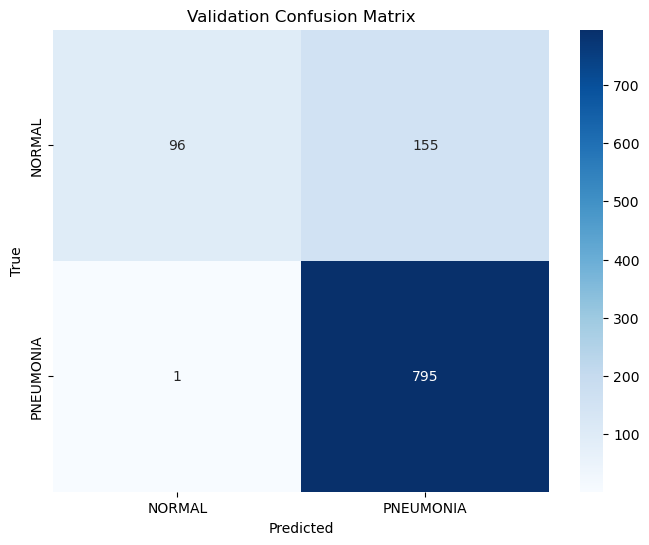

In [50]:
# Load the trained InceptionV3 model
inception_eval = models.inception_v3(pretrained=False)
inception_eval.fc = nn.Linear(inception_eval.fc.in_features, len(class_names))
inception_eval.load_state_dict(torch.load('inception_pneumonia_detection.pth'))
inception_eval.to(device)
inception_eval.eval()

# Lists to store predicted labels and true labels
val_predicted_labels = []
val_true_labels = []

# Disable gradient computation during evaluation
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = inception_eval(images)  # Only one output from InceptionV3
        _, predicted = outputs.max(1)

        # Update lists
        val_predicted_labels.extend(predicted.cpu().numpy())
        val_true_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays for consistency
val_true_labels_np = np.array(val_true_labels)
val_predicted_labels_np = np.array(val_predicted_labels)

# Calculate accuracy, precision, recall, and F1 score
val_accuracy = accuracy_score(val_true_labels_np, val_predicted_labels_np)
val_precision = precision_score(val_true_labels_np, val_predicted_labels_np)
val_recall = recall_score(val_true_labels_np, val_predicted_labels_np)
val_f1 = f1_score(val_true_labels_np, val_predicted_labels_np)

print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Precision: {val_precision * 100:.2f}%")
print(f"Validation Recall: {val_recall * 100:.2f}%")
print(f"Validation F1 Score: {val_f1 * 100:.2f}%")

# Calculate the confusion matrix for the validation set
val_conf_matrix = confusion_matrix(val_true_labels_np, val_predicted_labels_np)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## Step 5: Model Interpretability and Explainability

In [57]:
## Installing Lime
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 1.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=eabb8757b52dfb2327d9b045475ba52f7c744f6fba48248ecb66073864055586
  Stored in directory: /Users/raja/Library/Caches/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


### Implementing GradCAM for ResNet50

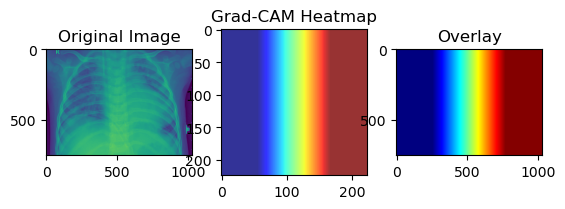

In [137]:
import torch
from torchvision import models, transforms
from torch.autograd import Function
from PIL import Image
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2

# Load your trained model (choose ResNet50 for this example)
resnet50 = models.resnet50(pretrained=True)
in_features = resnet50.fc.in_features
resnet50.fc = torch.nn.Linear(in_features, 2)  # Modify the fully connected layer
resnet50.load_state_dict(torch.load('resnet50_pneumonia_detection.pth'))
resnet50.eval()

# Define the device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50.to(device)

# Function to extract features using hooks
class FeatureExtractor:
    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.features = [None] * len(target_layers)  # Initialize features with None

        # Register hooks
        for name, layer in self.model._modules.items():
            if name in target_layers:
                layer.register_forward_hook(self.forward_hook)
                layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        name = [name for name, layer in self.model._modules.items() if layer == module][0]
        idx = self.target_layers.index(name)
        self.features[idx] = output.clone()

    def backward_hook(self, module, grad_input, grad_output):
        name = [name for name, layer in self.model._modules.items() if layer == module][0]
        idx = self.target_layers.index(name)
        self.features[idx].grad = grad_output[0].clone()

    def __call__(self, x):
        self.features = [None] * len(self.target_layers)  # Reset features before the forward pass
        self.model(x)
        return self.features

# Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()  # Set the model to evaluation mode
        self.target_layer = target_layer
        self.feature_extractor = FeatureExtractor(self.model, [self.target_layer])
        self.preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels for ResNet
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def generate_heatmap(self, image, target_class=None): 
        image_tensor = self.preprocess(image).unsqueeze(0).to(device)
        features = self.feature_extractor(image_tensor)
        output = self.model(image_tensor)

        if target_class is None:
            target_class = torch.argmax(output)

        one_hot = torch.zeros((1, output.size()[-1]), dtype=torch.float32, device=device)
        one_hot[0][target_class] = 1
        one_hot = torch.sum(one_hot * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.feature_extractor.features[0].grad
        if grads_val is None:
            raise RuntimeError(f"Gradient is None for target layer {self.target_layer}. Make sure the target layer is correct.")

        target = self.feature_extractor.features[0]
        
        spatial_dimensions = tuple(range(grads_val.ndim)[2:])

        weights = torch.mean(grads_val, dim=spatial_dimensions, keepdim=True).unsqueeze(2).unsqueeze(3)

        cam = torch.sum(weights * target, dim=1, keepdim=True)

        cam = F.relu(cam)
        cam = F.interpolate(cam, (224, 224), mode="bilinear", align_corners=False)
        cam = cam.squeeze()
        heatmap = cam.detach().cpu().numpy()
        heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap) + 1e-5)
        
        return heatmap

    def generate_heatmap_with_overlay(self, image, target_class=None):
        image_tensor = self.preprocess(image).unsqueeze(0).to(device)
        features = self.feature_extractor(image_tensor)
        output = self.model(image_tensor)

        if target_class is None:
            target_class = torch.argmax(output)

        one_hot = torch.zeros((1, output.size()[-1]), dtype=torch.float32, device=device)
        one_hot[0][target_class] = 1
        one_hot = torch.sum(one_hot * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.feature_extractor.features[0].grad
        if grads_val is None:
            raise RuntimeError(f"Gradient is None for target layer {self.target_layer}. Make sure the target layer is correct.")

        target = self.feature_extractor.features[0]
        spatial_dimensions = tuple(range(grads_val.ndim)[2:])
        weights = torch.mean(grads_val, dim=spatial_dimensions, keepdim=True).unsqueeze(2).unsqueeze(3)
        cam = torch.sum(weights * target, dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, (224, 224), mode="bilinear", align_corners=False)
        cam = cam.squeeze()

        heatmap = cam.detach().cpu().numpy()
        heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap) + 1e-5)

        # Resize heatmap to match the original image size
        heatmap_resized = cv2.resize(heatmap, (image.width, image.height))

        # Normalize the heatmap values to be in the range [0, 255]
        heatmap_rescaled = np.uint8(255 * heatmap_resized)

        # Apply a colormap (e.g., jet) to the heatmap
        heatmap_colored = cv2.applyColorMap(heatmap_rescaled, cv2.COLORMAP_JET)

        # Convert heatmap to RGBA format
        heatmap_rgba = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGBA)

        # Convert the original image to RGBA format
        image_rgba = image.convert("RGBA")

        # Convert NumPy arrays to PIL Images
        heatmap_pil = Image.fromarray(heatmap_rgba)
        image_pil = Image.fromarray(np.array(image_rgba))

        # Blend the original image and the heatmap
        overlay = Image.alpha_composite(image_pil, heatmap_pil)

        return heatmap, overlay


#Usage of Grad-CAM with overlay
grad_cam = GradCAM(resnet50, target_layer='fc')
example_image_path = '/Users/raja/Desktop/Career/Masters/Universities/mtu/Fall2023/Clinical Decision and Support System/Final Project/dataset/chest_xray/test/PNEUMONIA/BACTERIA-1135262-0003.jpeg'
example_image = Image.open(example_image_path)
heatmap, overlay = grad_cam.generate_heatmap_with_overlay(example_image)

# Display the original image, Grad-CAM heatmap, and overlay
plt.subplot(1, 3, 1)
plt.imshow(example_image)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap='jet', alpha=0.8)
plt.title('Grad-CAM Heatmap')

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title('Overlay')
plt.show()

### Implementing LIME for ResNet50

/Users/raja/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/raja/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

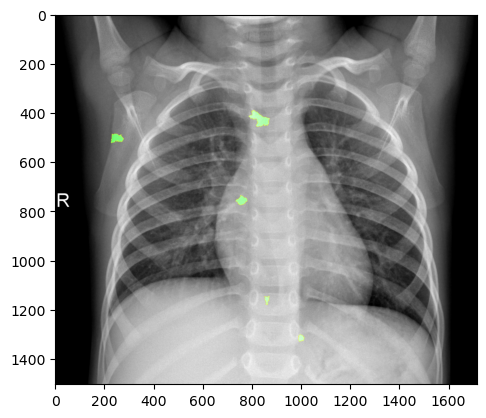

In [181]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Load your trained model (replace 'your_model.pth' with the path to your model's state_dict)
resnet50 = models.resnet50(pretrained=True)
in_features = resnet50.fc.in_features
resnet50.fc = torch.nn.Linear(in_features, 2)  # Modify the fully connected layer
resnet50.load_state_dict(torch.load('resnet50_pneumonia_detection.pth'))
resnet50.eval()

# Define the device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50.to(device)

# Define transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the example image
example_image_path = '/Users/raja/Desktop/Career/Masters/Universities/mtu/Fall2023/Clinical Decision and Support System/Final Project/dataset/chest_xray/train/NORMAL/NORMAL-159556-0001.jpeg'
example_image = Image.open(example_image_path).convert("RGB")

# Preprocess the image
input_tensor = preprocess(example_image)
input_batch = input_tensor.unsqueeze(0).to(device)

# Class names for binary classification (replace with your actual class names)
class_names = ['Normal', 'Pneumonia']

# Predict class probabilities
with torch.no_grad():
    model_output = resnet50(input_batch)
softmax_probs = torch.nn.functional.softmax(model_output[0], dim=0).cpu().numpy()

# LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explanation for the predicted class
def classifier_fn(images):
    images = (images * 255).astype(np.uint8)  # Convert to uint8
    images = images.transpose((0, 3, 1, 2))  # Transpose dimensions
    images = torch.from_numpy(images).to(device).float() / 255.0  # Normalize to [0, 1]
    with torch.no_grad():
        model_output = resnet50(images)
    return torch.nn.functional.softmax(model_output, dim=1).cpu().numpy()



# Convert the image to a NumPy array
example_image_np = np.array(example_image)

# Explanation using LIME
explanation = explainer.explain_instance(
    example_image_np,
    classifier_fn=classifier_fn,
    top_labels=2,
    hide_color=0,
    num_samples=1000
)

# Display the LIME explanation
lime_img, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=False,
    num_features=5,
    hide_rest=False
)

plt.imshow(mark_boundaries(lime_img, mask))
plt.show()

## Step 6: Results

### Model Evaluation and Comparisons

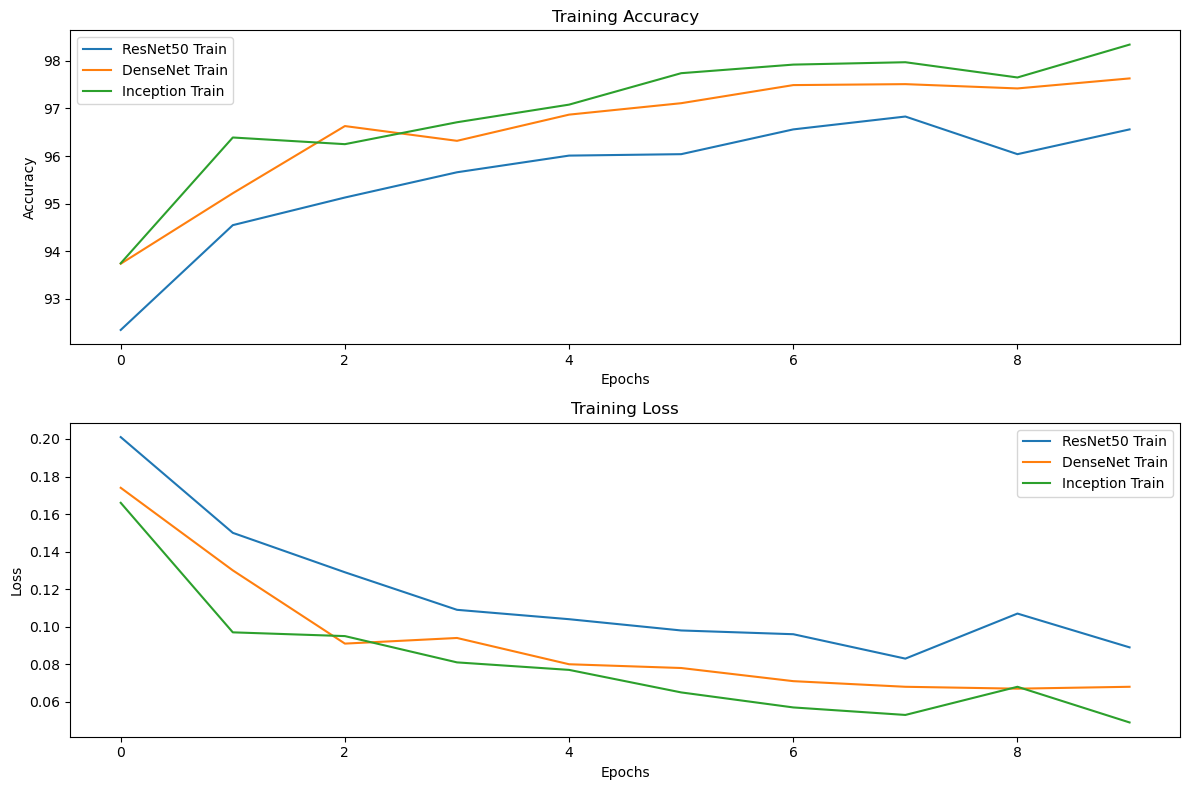

In [175]:
import matplotlib.pyplot as plt

# ResNet50
resnet50_train_loss = [0.201, 0.150, 0.129, 0.109, 0.104, 0.098, 0.096, 0.083, 0.107, 0.089]
resnet50_train_accuracy = [92.35, 94.55, 95.13, 95.66, 96.01, 96.04, 96.56, 96.83, 96.04, 96.56]
resnet50_val_accuracy = [95.51]  

# DenseNet
densenet_train_loss = [0.174, 0.130, 0.091, 0.094, 0.080, 0.078, 0.071, 0.068, 0.067, 0.068]
densenet_train_accuracy = [93.74, 95.22, 96.63, 96.32, 96.87, 97.11, 97.49, 97.51, 97.42, 97.63]
densenet_val_accuracy = [97.42] 

# Inception
inception_train_loss = [0.166, 0.097, 0.095, 0.081, 0.077, 0.065, 0.057, 0.053, 0.068, 0.049]
inception_train_accuracy = [93.75, 96.39, 96.25, 96.71, 97.08, 97.74, 97.92, 97.97, 97.65, 98.34]
inception_val_accuracy = [85.10]  

# Plotting the learning curves
plt.figure(figsize=(12, 8))

# Training accuracy
plt.subplot(2, 1, 1)
plt.plot(resnet50_train_accuracy, label='ResNet50 Train')
plt.plot(densenet_train_accuracy, label='DenseNet Train')
plt.plot(inception_train_accuracy, label='Inception Train')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Training loss
plt.subplot(2, 1, 2)
plt.plot(resnet50_train_loss, label='ResNet50 Train')
plt.plot(densenet_train_loss, label='DenseNet Train')
plt.plot(inception_train_loss, label='Inception Train')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

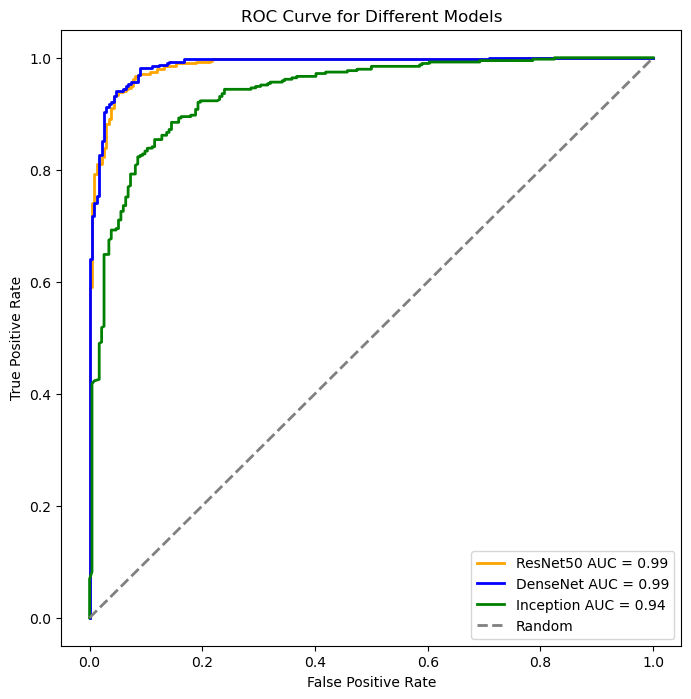

In [176]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Function to calculate ROC and AUC
def calculate_roc_auc(model, dataloader):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of positive class
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc

# Calculate ROC and AUC for each model
resnet50_fpr, resnet50_tpr, resnet50_roc_auc = calculate_roc_auc(resnet50, validation_dataloader)
densenet_fpr, densenet_tpr, densenet_roc_auc = calculate_roc_auc(densenet, validation_dataloader)
inception_fpr, inception_tpr, inception_roc_auc = calculate_roc_auc(inception, validation_dataloader)

# Plot ROC curves
plt.figure(figsize=(8, 8))
plt.plot(resnet50_fpr, resnet50_tpr, color='orange', lw=2, label=f'ResNet50 AUC = {resnet50_roc_auc:.2f}')
plt.plot(densenet_fpr, densenet_tpr, color='blue', lw=2, label=f'DenseNet AUC = {densenet_roc_auc:.2f}')
plt.plot(inception_fpr, inception_tpr, color='green', lw=2, label=f'Inception AUC = {inception_roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Models')
plt.legend()
plt.show()


/Users/raja/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/raja/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/Users/raja/anaconda3/lib/python3.11/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


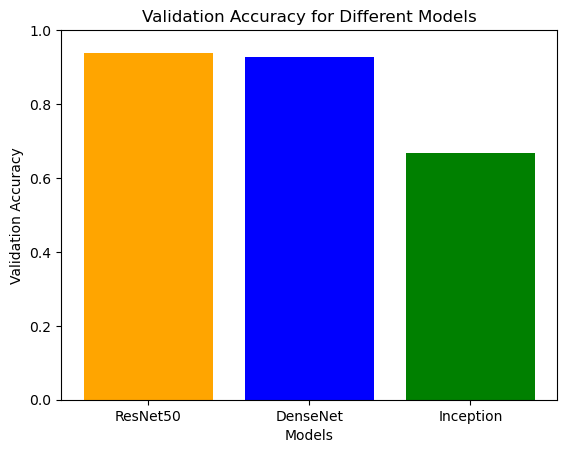

In [164]:
import torch
from torchvision import transforms, models
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import os

# DataLoader for your validation dataset
validation_dataset = test_dataset  
validation_dataloader = test_loader  

# Function to calculate accuracy
def calculate_accuracy(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)

    return acc

# Load the saved models
resnet50 = models.resnet50(pretrained=False)
resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, 2)
resnet50.load_state_dict(torch.load('resnet50_pneumonia_detection.pth'))
resnet50.eval()

densenet = models.densenet121(pretrained=False)
densenet.classifier = torch.nn.Linear(densenet.classifier.in_features, 2)
densenet.load_state_dict(torch.load('densenet_pneumonia_detection.pth'))
densenet.eval()

inception = models.inception_v3(pretrained=False)
inception.fc = torch.nn.Linear(inception.fc.in_features, 2)
inception.load_state_dict(torch.load('inception_pneumonia_detection.pth'))
inception.eval()

# Calculate accuracy for each model
resnet50_acc = calculate_accuracy(resnet50, validation_dataloader)
densenet_acc = calculate_accuracy(densenet, validation_dataloader)
inception_acc = calculate_accuracy(inception, validation_dataloader)

# Plot bar graph
models = ['ResNet50', 'DenseNet', 'Inception']
accuracies = [resnet50_acc, densenet_acc, inception_acc]

plt.bar(models, accuracies, color=['orange', 'blue', 'green'])
plt.xlabel('Models')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Different Models')
plt.ylim(0, 1) 
plt.show()


#### All Our Trained Models Random Image Predictions

resnet50 Model Random Chest-Xray Predictions


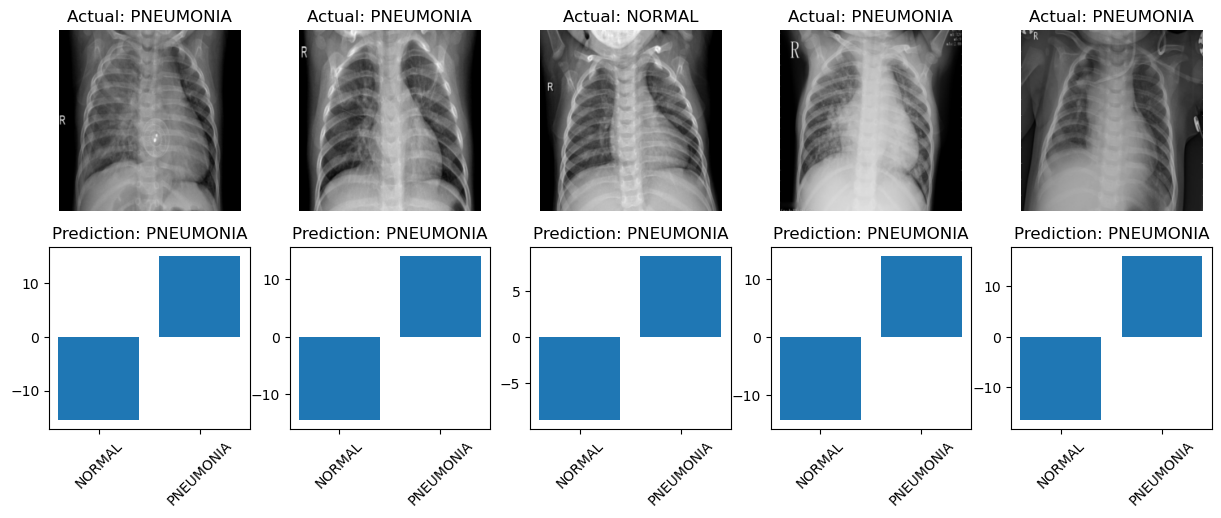

densenet Model Random Chest-Xray Predictions


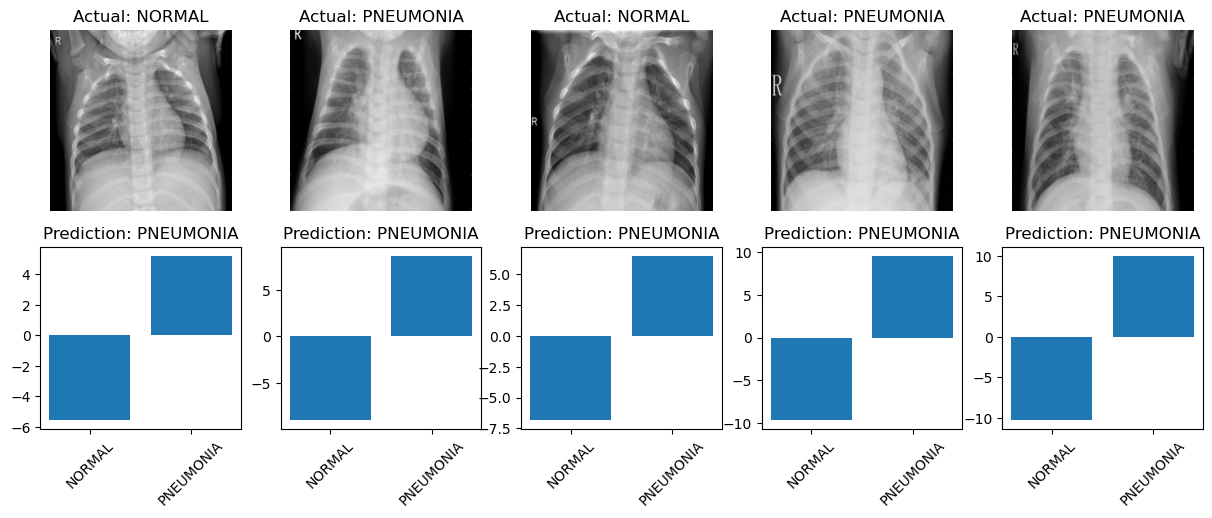

inception Model Random Chest-Xray Predictions


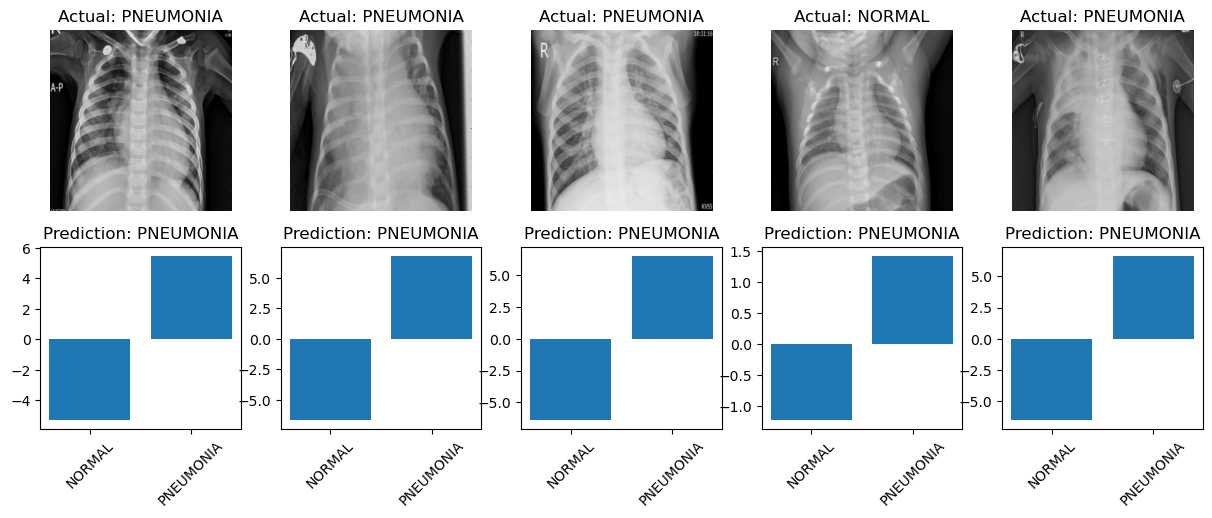

In [173]:
import torch
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize random images with predictions
def visualize_random_images(model, dataloader, class_names, num_images=5):
    model.eval()

    # Get some random images and their labels from the dataset
    images, labels = next(iter(dataloader))
    
    # Make predictions
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    # Display the images along with their predictions and actual labels
    plt.figure(figsize=(15, 8))
    for i in range(num_images):
        plt.subplot(3, num_images, i + 1)
        plt.imshow(np.transpose(images[i].cpu().numpy(), (1, 2, 0)))
        plt.title(f'Actual: {class_names[labels[i].item()]}')
        plt.axis('off')

        plt.subplot(3, num_images, num_images + i + 1)
        plt.bar(range(len(class_names)), outputs[i].cpu().numpy())
        plt.xticks(range(len(class_names)), class_names, rotation=45)
        plt.title(f'Prediction: {class_names[preds[i].item()]}')

    plt.show()

# Load the saved models
resnet50 = models.resnet50(pretrained=False)
resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, 2)
resnet50.load_state_dict(torch.load('resnet50_pneumonia_detection.pth'))
resnet50.eval()

densenet = models.densenet121(pretrained=False)
densenet.classifier = torch.nn.Linear(densenet.classifier.in_features, 2)
densenet.load_state_dict(torch.load('densenet_pneumonia_detection.pth'))
densenet.eval()

inception = models.inception_v3(pretrained=False)
inception.fc = torch.nn.Linear(inception.fc.in_features, 2)
inception.load_state_dict(torch.load('inception_pneumonia_detection.pth'))
inception.eval()

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create a DataLoader for random images
random_dataset = ImageFolder('/Users/raja/Desktop/Career/Masters/Universities/mtu/Fall2023/Clinical Decision and Support System/Final Project/dataset/chest_xray/train', transform=transform)
random_dataloader = DataLoader(random_dataset, batch_size=5, shuffle=True)

# Class names for your dataset
class_names = ['NORMAL', 'PNEUMONIA']

# Visualize random images for each model
print("resnet50 Model Random Chest-Xray Predictions")
visualize_random_images(resnet50, random_dataloader, class_names)
print("densenet Model Random Chest-Xray Predictions")
visualize_random_images(densenet, random_dataloader, class_names)
print("inception Model Random Chest-Xray Predictions")
visualize_random_images(inception, random_dataloader, class_names)

#### Confusion Matrix Comparision

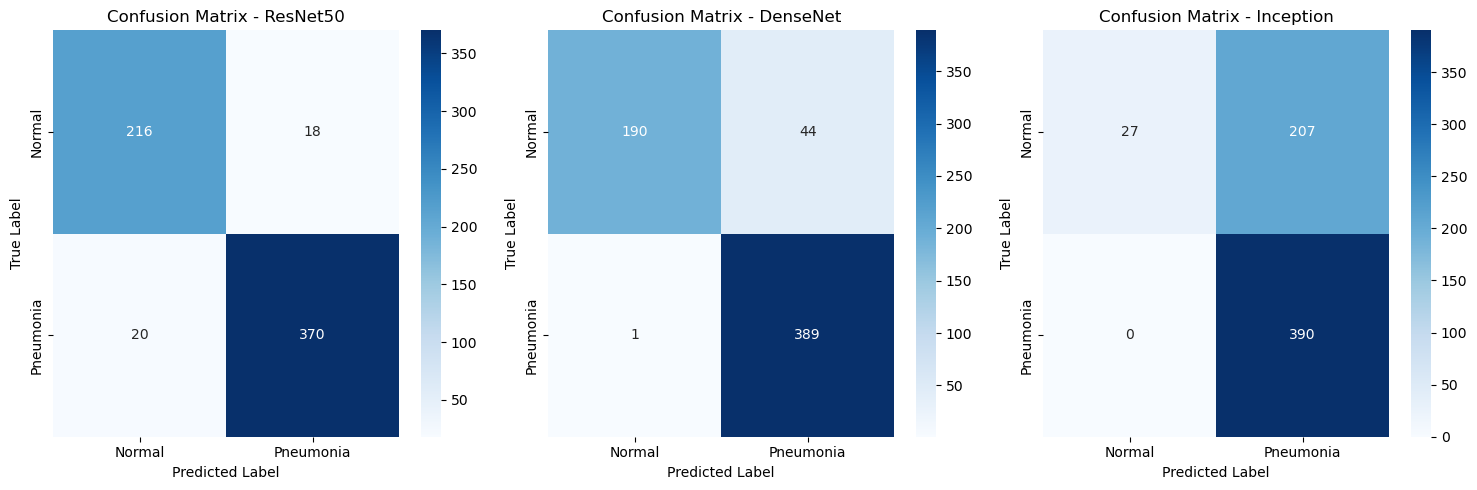

The best model based on validation accuracy is: ResNet50


In [177]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# Function to calculate confusion matrix
def calculate_confusion_matrix(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    return cm

# Calculate confusion matrix for each model
resnet50_cm = calculate_confusion_matrix(resnet50, validation_dataloader)
densenet_cm = calculate_confusion_matrix(densenet, validation_dataloader)
inception_cm = calculate_confusion_matrix(inception, validation_dataloader)

# Plot confusion matrices
models = ['ResNet50', 'DenseNet', 'Inception']
cms = [resnet50_cm, densenet_cm, inception_cm]

plt.figure(figsize=(15, 5))

for i, (model, cm) in enumerate(zip(models, cms), 1):
    plt.subplot(1, 3, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
    plt.title(f'Confusion Matrix - {model}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

plt.tight_layout()
plt.show()